<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/kmeans_walkforward_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!Protocol Buffer Fix (for TensorFlow)
!pip install --upgrade protobuf
!pip install protobuf==3.20.3

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `Protocol Buffer Fix (for TensorFlow)'
  Using cached protobuf-6.31.0-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached protobuf-6.31.0-cp39-abi3-manylinux2014_x86_64.whl (320 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 6.31.0 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.0 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.

In [2]:
!pip install tensorflow

In [3]:
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib

In [4]:
import torch
import cudf
import cuml
import dask
import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import gymnasium as gym
import stable_baselines3

#Version Checks
print("Library Versions")
print("--------------------")
print("PyTorch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("cuDF:", cudf.__version__)
print("cuML:", cuml.__version__)
print("Dask:", dask.__version__)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("LightGBM:", lgb.__version__)
print("Gymnasium:", gym.__version__)
print("Stable Baselines3:", stable_baselines3.__version__)

#GPU Check (Torch + NVIDIA)
print("\nGPU Availability")
print("--------------------")
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


Library Versions
--------------------
PyTorch: 2.6.0+cu124
CUDA: 12.4
cuDF: 25.02.01
cuML: 25.02.01
Dask: 2024.12.1
Pandas: 2.2.2
NumPy: 2.0.2
SciPy: 1.15.3
LightGBM: 4.5.0
Gymnasium: 1.1.1
Stable Baselines3: 2.6.0

GPU Availability
--------------------
PyTorch GPU Available: False
GPU Count: 0


In [5]:
#Core Libraries
import gc
import json
import os
import pickle
import sys
import time
from collections import defaultdict, deque
from datetime import datetime

#Data Science Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import IPython.display as display

#Machine Learning & Data Processing
import joblib
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler

#Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model

#RAPIDS Libraries (cuDF & cuML for GPU acceleration)
import cupy as cp

#Reinforcement Learning (Stable Baselines3)
import stable_baselines3
from stable_baselines3 import A2C, DDPG, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

#Gym & Trading Environments
import gym
import gymnasium as gym
import gym_anytrading
from gym.spaces import Box
from gymnasium.spaces import Box as GymBox, Discrete
from gymnasium.wrappers import TimeLimit
from gym_anytrading.envs import StocksEnv

#Financial & Stock Data Libraries
import yfinance as yf

#PyTorch Essentials
import torch
import torch.nn as nn
import torch.optim as optim


In [6]:
#Set CUDA Paths (Ensuring GPU Utilization)
os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

In [7]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
import yfinance as yf
import time
import pandas as pd
from datetime import datetime, timedelta

#Setup
RESULTS_DIR = "results/kmeans_walkforward"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/models", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/data", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/signals", exist_ok=True)
os.makedirs(f"{RESULTS_DIR}/plots", exist_ok=True)

#Ticker list
TICKERS = [
    'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
    'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
    'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
    'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
    'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
    'GE', 'SBUX', 'ORCL'
]
SEQUENCE_LENGTH = 60
EPOCHS = 10
BATCH_SIZE = 32
LSTM_DIR = "results/lstm_walkforward"
KMEANS_DIR = "results/kmeans_walkforward"
os.makedirs(LSTM_DIR, exist_ok=True)
os.makedirs(KMEANS_DIR, exist_ok=True)

RESULTS_DIR = "results/kmeans_walkforward"
os.makedirs(RESULTS_DIR, exist_ok=True)

ANALYZE_METHODS = True
anomaly_eval_summary = []

def download_data(ticker, retries=3, sleep_time=10):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=720)
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    for attempt in range(retries):
        try:
            df = yf.download(ticker, start=start_str, end=end_str, interval="1h", progress=False)
            if not df.empty:
                df.reset_index(inplace=True)
                df['Datetime'] = pd.to_datetime(df['Datetime'])
                return df
        except Exception as e:
            print(f"Error downloading {ticker} (Attempt {attempt + 1}): {e}")
            time.sleep(sleep_time)
    print(f"iled to download {ticker} after {retries} attempts.")
    return None




In [9]:
#Utility Functions

def fix_dataframe_index(df):
    """
    Flattens MultiIndex columns and removes duplicated columns.
    """
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df.loc[:, ~df.columns.duplicated()]


def calculate_rsi(series, period=14):
    """
    Calculates the Relative Strength Index (RSI) for a given price series.
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))


def compute_technical_indicators(df):
    """
    Applies technical indicators including RSI, MACD, Bollinger Bands, Stochastic Oscillator,
    OBV, CCI, momentum, trend, and volatility indicators.
    """
    df = df.copy()
    df = fix_dataframe_index(df)

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
    df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']

    df['Lowest_Low'] = df['Low'].rolling(window=14).min()
    df['Highest_High'] = df['High'].rolling(window=14).max()
    denominator = (df['Highest_High'] - df['Lowest_Low']).replace(0, np.nan)
    df['Stoch'] = ((df['Close'] - df['Lowest_Low']) / denominator) * 100

    df['volatility'] = df['Close'].pct_change().rolling(20).std()
    df['ROC'] = df['Close'].pct_change(periods=10)

    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (
        0.015 * typical_price.rolling(20).std()
    )

    df['PROC'] = ((df['Close'] - df['Close'].shift(12)) / df['Close'].shift(12)) * 100

    df['Rolling_Mean_50'] = df['Close'].rolling(window=50).mean()
    df['Expanding_Mean'] = df['Close'].expanding(min_periods=1).mean()

    df.dropna(inplace=True)
    return df


def generate_trade_labels(df, lookahead=10, threshold_factor=2):
    """
    Generates binary and dynamic trade labels based on future returns
    and volatility-adjusted thresholds.
    """
    df = df.copy()
    df = fix_dataframe_index(df)

    if 'Close' not in df.columns:
        raise KeyError("'Close' column is missing. Cannot generate trade labels.")

    df['Future_Close'] = df['Close'].shift(-lookahead)
    df['Price_Change'] = (df['Future_Close'] - df['Close']) / df['Close']
    df['Target'] = np.where(df['Price_Change'] > 0.03, 1, 0)

    buy_threshold = df['volatility'] * threshold_factor
    sell_threshold = -df['volatility'] * threshold_factor

    df['Dynamic_Label'] = np.where(
        df['Price_Change'] > buy_threshold, 1,
        np.where(df['Price_Change'] < sell_threshold, -1, 0)
    )

    df.dropna(inplace=True)
    return df


def drop_low_importance_features(df, feature_importance_df, threshold=1.0):
    """
    Drops low-importance features based on a given threshold.
    """
    low_importance_features = feature_importance_df[
        feature_importance_df['importance'] < threshold
    ]['feature'].tolist()

    if low_importance_features:
        df.drop(columns=low_importance_features, inplace=True)
        print(f"Dropped low-importance features: {low_importance_features}")
    else:
        print("No low-importance features found to drop.")

    return df


In [14]:
import os
import gc
import joblib
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import Image, display
from google.colab import drive
drive.mount('/content/drive')

RESULTS_DIR = "/content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results"
os.makedirs(RESULTS_DIR + "/plots", exist_ok=True)
os.makedirs(RESULTS_DIR + "/data", exist_ok=True)



# === Walkforward KMeans Strategy ===
def walkforward_kmeans(df, n_clusters=3):
    df = df.copy()
    df = compute_technical_indicators(df)

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.sort_values('Datetime')

    latest_date = df['Datetime'].max()
    train_start = latest_date - pd.Timedelta(days=730)
    train_end = latest_date - pd.Timedelta(days=365)
    test_end = latest_date

    train_df = df[(df['Datetime'] >= train_start) & (df['Datetime'] < train_end)].copy()
    test_df = df[(df['Datetime'] >= train_end) & (df['Datetime'] <= test_end)].copy()

    print(f" {df['Datetime'].min().date()} to {df['Datetime'].max().date()} | Train: {len(train_df)}, Test: {len(test_df)}")

    if len(train_df) < 30 or len(test_df) < 30:
        return None, None, None

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[['RSI', 'MACD', 'OBV']])
    X_test = scaler.transform(test_df[['RSI', 'MACD', 'OBV']])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train)
    test_df['cluster'] = kmeans.predict(X_test)

    test_df['return'] = test_df['Close'].pct_change().fillna(0)
    test_df['strategy'] = test_df['cluster'].shift(1).fillna(0) * test_df['return']
    test_df['cumulative_market'] = (1 + test_df['return']).cumprod()
    test_df['cumulative_strategy'] = (1 + test_df['strategy']).cumprod()


    test_df['Forward_Return'] = test_df['Close'].pct_change(periods=10).shift(-10)
    cluster_returns = test_df.groupby('cluster')['Forward_Return'].mean().sort_values(ascending=False)
    signal_labels = ['Buy', 'Hold', 'Sell']
    signal_map = {cluster: signal_labels[i] if i < len(signal_labels) else 'Hold'
                  for i, cluster in enumerate(cluster_returns.index)}
    test_df['signal'] = test_df['cluster'].map(signal_map)
    test_df['Portfolio_Value'] = test_df['strategy'].cumsum()  # Optional: can replace with cumulative_strategy

    stats = {
        "Final Market": test_df['cumulative_market'].iloc[-1],
        "Final Strategy": test_df['cumulative_strategy'].iloc[-1],
        "Sharpe": test_df['strategy'].mean() / (test_df['strategy'].std() + 1e-6) * np.sqrt(252),
        "Drawdown": (test_df['cumulative_strategy'].cummax() - test_df['cumulative_strategy']).max(),
        "Final Portfolio Value": test_df['Portfolio_Value'].iloc[-1],
        "Signal Map": signal_map
    }

    return stats, test_df, kmeans

# === Main Execution ===
summary = []
top_portfolios = {}

for ticker in TICKERS:
    print(f"\nProsing {ticker}")
    df = yf.download(ticker, period="730d", interval="1h", progress=False)
    if df is None or df.empty:
        print(f"Skipping {ticker}, no data.")
        continue

    df.reset_index(inplace=True)
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    stats, result_df, model = walkforward_kmeans(df)
    if result_df is None:
        print(f"Skipping {ticker}, insufficient train/test rows.")
        continue

    #Move this OUTSIDE of the if-block
    stats.update({
        "Ticker": ticker,
        "Model": "KMeans",  # Can be dynamic later
        "Accuracy": np.nan,
        "Precision": np.nan,
        "Recall": np.nan,
        "F1_Score": np.nan,
        "Return": result_df['strategy'].sum()
    })
    summary.append(stats)

    result_df.to_csv(f"{RESULTS_DIR}/data/{ticker}_result.csv", index=False)
    joblib.dump(model, f"{RESULTS_DIR}/{ticker}_model.pkl")

    top_portfolios[ticker] = result_df[['Portfolio_Value']].copy()
    gc.collect()


# === Save Summary and Plots ===
summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values('Final Portfolio Value', ascending=False)
summary_df.to_csv(f"{RESULTS_DIR}/summary_forward_return_remap.csv", index=False)

print("\nSummary with forward return signal mapping saved.")
print(summary_df[['Ticker', 'Final Strategy', 'Final Portfolio Value', 'Sharpe', 'Drawdown']].head())


summary_df['score'] = (
    summary_df['Sharpe'] * 0.4 +
    summary_df['Final Strategy'] * 0.3 +
    summary_df['Final Portfolio Value'] * 0.3
)

summary_df.to_csv(f"{RESULTS_DIR}/model_selector_metrics.csv", index=False)

best_models = summary_df.sort_values(['Ticker', 'score'], ascending=[True, False])\
                        .groupby('Ticker').first().reset_index()

best_models.to_excel(f"{RESULTS_DIR}/best_models_by_score.xlsx", index=False)


# === Plot Top 5 Performers ===
top_tickers = summary_df.head(5)['Ticker']
for ticker in top_tickers:
    file_path = f"{RESULTS_DIR}/data/{ticker}_result.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        plt.figure(figsize=(12, 6))
        plt.plot(df['cumulative_market'], label='Market (Buy & Hold)', linestyle='-')
        plt.plot(df['cumulative_strategy'], label='KMeans Strategy', linestyle='--')
        plt.title(f"{ticker} - Cumulative Returns")
        plt.xlabel("Time Steps")
        plt.ylabel("Cumulative Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plot_path = f"{RESULTS_DIR}/plots/{ticker}_portfolio_plot.png"
        plt.savefig(plot_path, dpi=300)
        plt.close()
        print(f"Plot saved for {ticker}: {plot_path}")
    else:
        print(f"Result CSV not found for {ticker}: {file_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Prosing AAPL
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing TSLA
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing MSFT
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing GOOGL
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing AMZN
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing NVDA
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing META
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing BRK-B
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing JPM
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing JNJ
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing XOM
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing V
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing PG
 2022-07-08 to 2025-05-23 | Train: 1749, Test: 1739

Prosing UNH
 2022-

In [15]:
import os
print(os.path.expanduser("~/Desktop"))


/root/Desktop


In [16]:
import os
import joblib
import json
import pandas as pd

def save_kmeans_results(
    stock,
    model,
    result_df,
    signal_map,
    stats,
    directory="results/kmeans_walkforward"
):
    os.makedirs(f"{directory}/models", exist_ok=True)
    os.makedirs(f"{directory}/data", exist_ok=True)
    os.makedirs(f"{directory}/signals", exist_ok=True)

    # Save model
    model_path = f"{directory}/models/{stock}_kmeans_model.pkl"
    joblib.dump(model, model_path)

    # Save results
    result_path = f"{directory}/data/{stock}_result.csv"
    result_df.to_csv(result_path, index=False)

    # Save signal map
    signal_map_path = f"{directory}/signals/{stock}_signal_map.json"
    with open(signal_map_path, "w") as f:
        json.dump(signal_map, f, indent=4)

    # Update summary
    summary_row = {
        "Ticker": stock,
        "Final Strategy": stats.get("Final Strategy"),
        "Final Portfolio Value": stats.get("Final Portfolio Value"),
        "Sharpe": stats.get("Sharpe"),
        "Drawdown": stats.get("Drawdown")
    }

    summary_path = f"{directory}/summary_kmeans_saved.csv"
    if os.path.exists(summary_path):
        summary_df = pd.read_csv(summary_path)
        summary_df = summary_df[summary_df["Ticker"] != stock]  # Remove old entry
        summary_df = pd.concat([summary_df, pd.DataFrame([summary_row])], ignore_index=True)
    else:
        summary_df = pd.DataFrame([summary_row])

    summary_df.to_csv(summary_path, index=False)

    print(f"Saved KMeans results for {stock}")
    return {
        "ticker": stock,
        "model_path": model_path,
        "result_path": result_path,
        "signal_map_path": signal_map_path,
        "summary_path": summary_path,
        "saved": True
    }


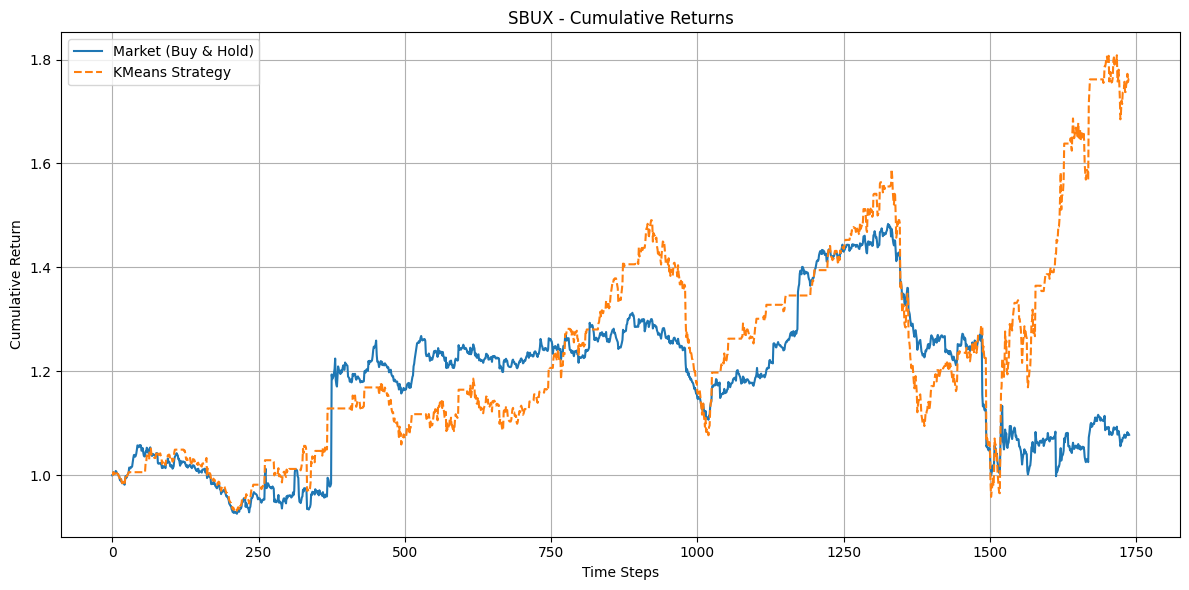

Plot saved for SBUX: /content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results/plots/SBUX_portfolio_plot.png


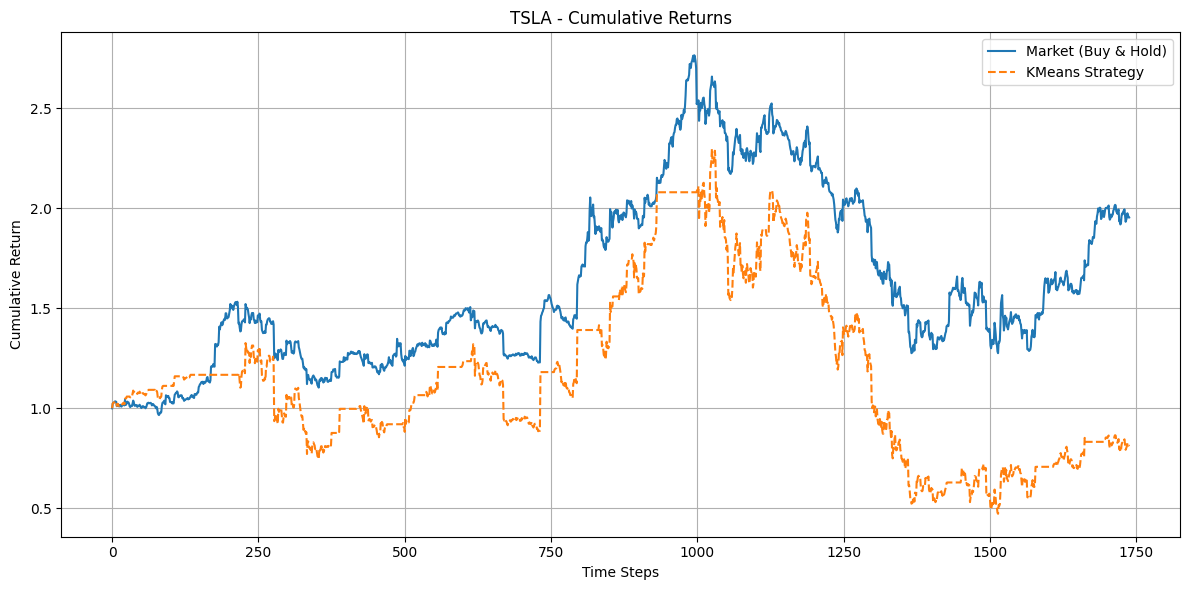

Plot saved for TSLA: /content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results/plots/TSLA_portfolio_plot.png


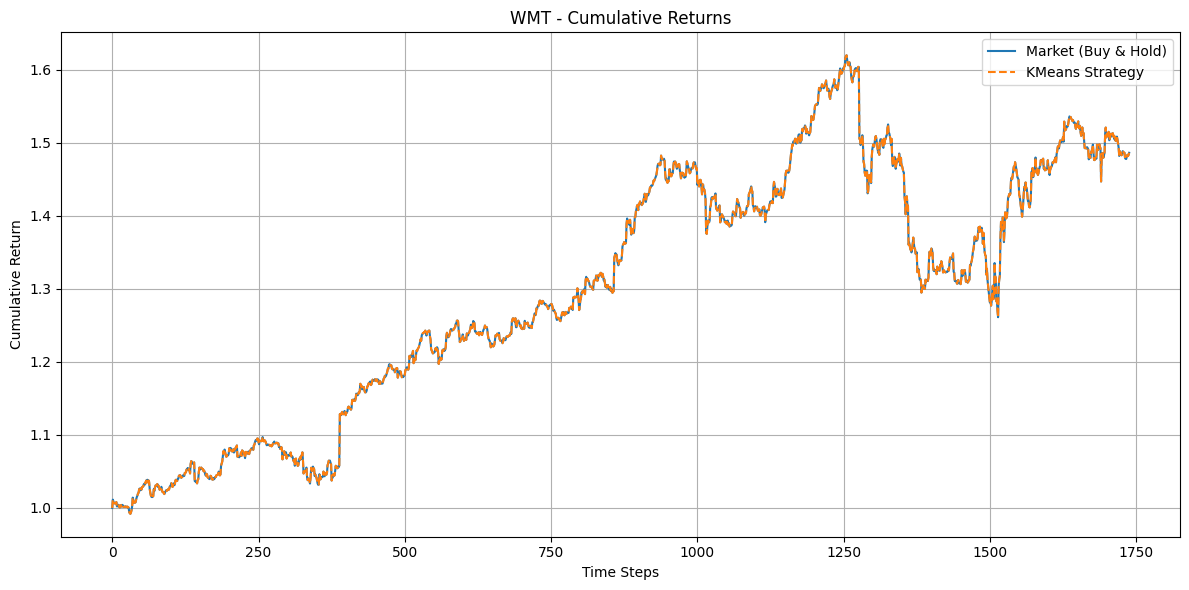

Plot saved for WMT: /content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results/plots/WMT_portfolio_plot.png


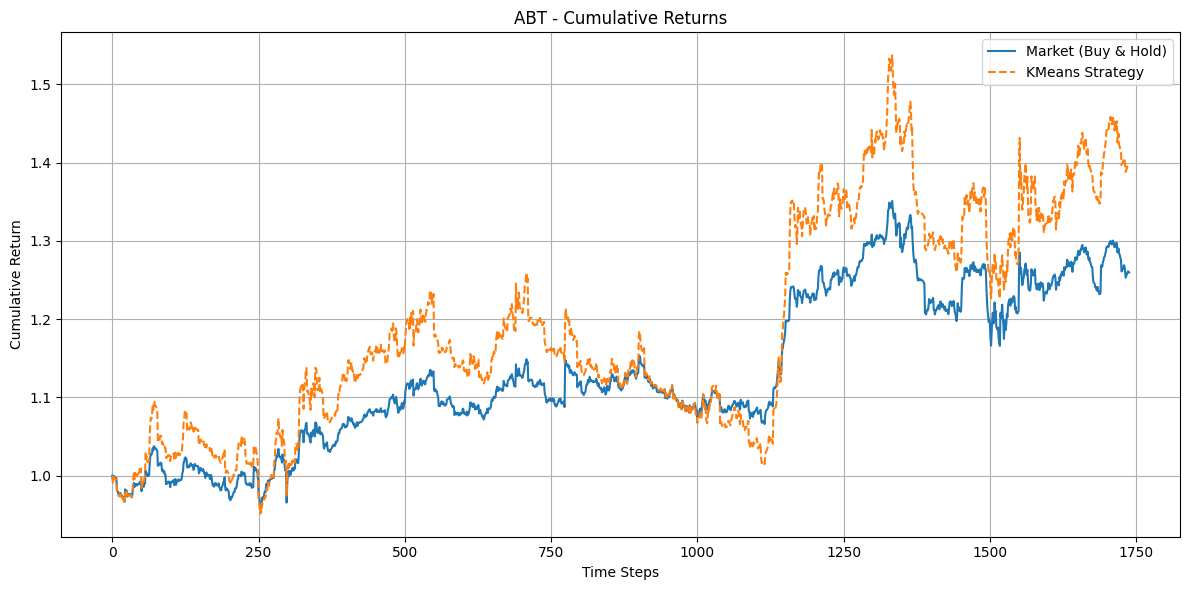

Plot saved for ABT: /content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results/plots/ABT_portfolio_plot.png


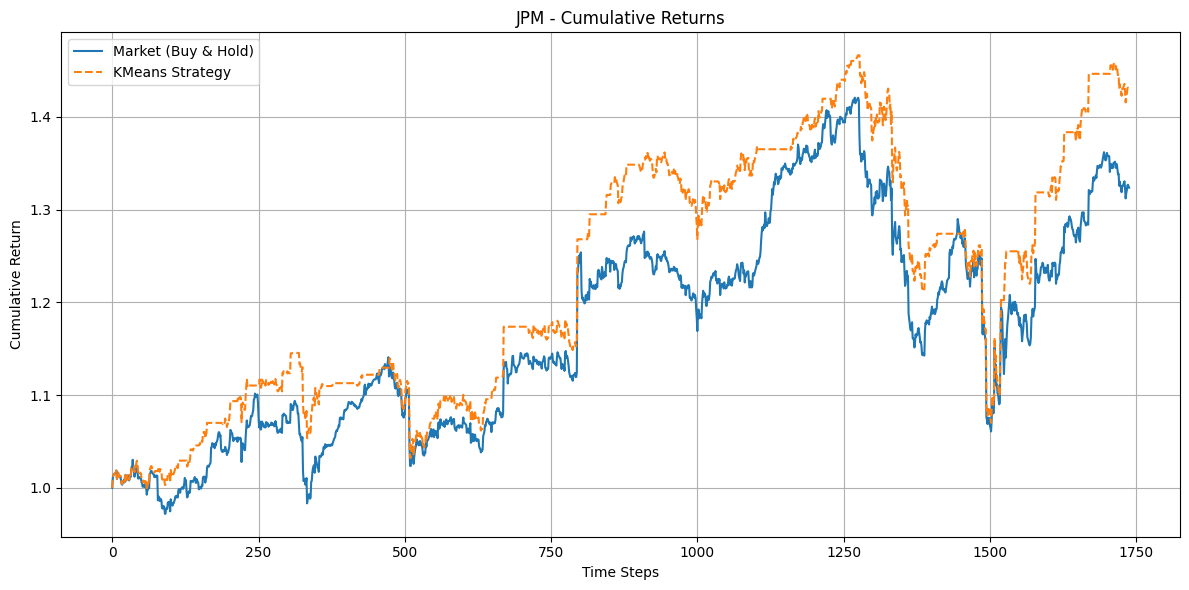

Plot saved for JPM: /content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results/plots/JPM_portfolio_plot.png

SBUX


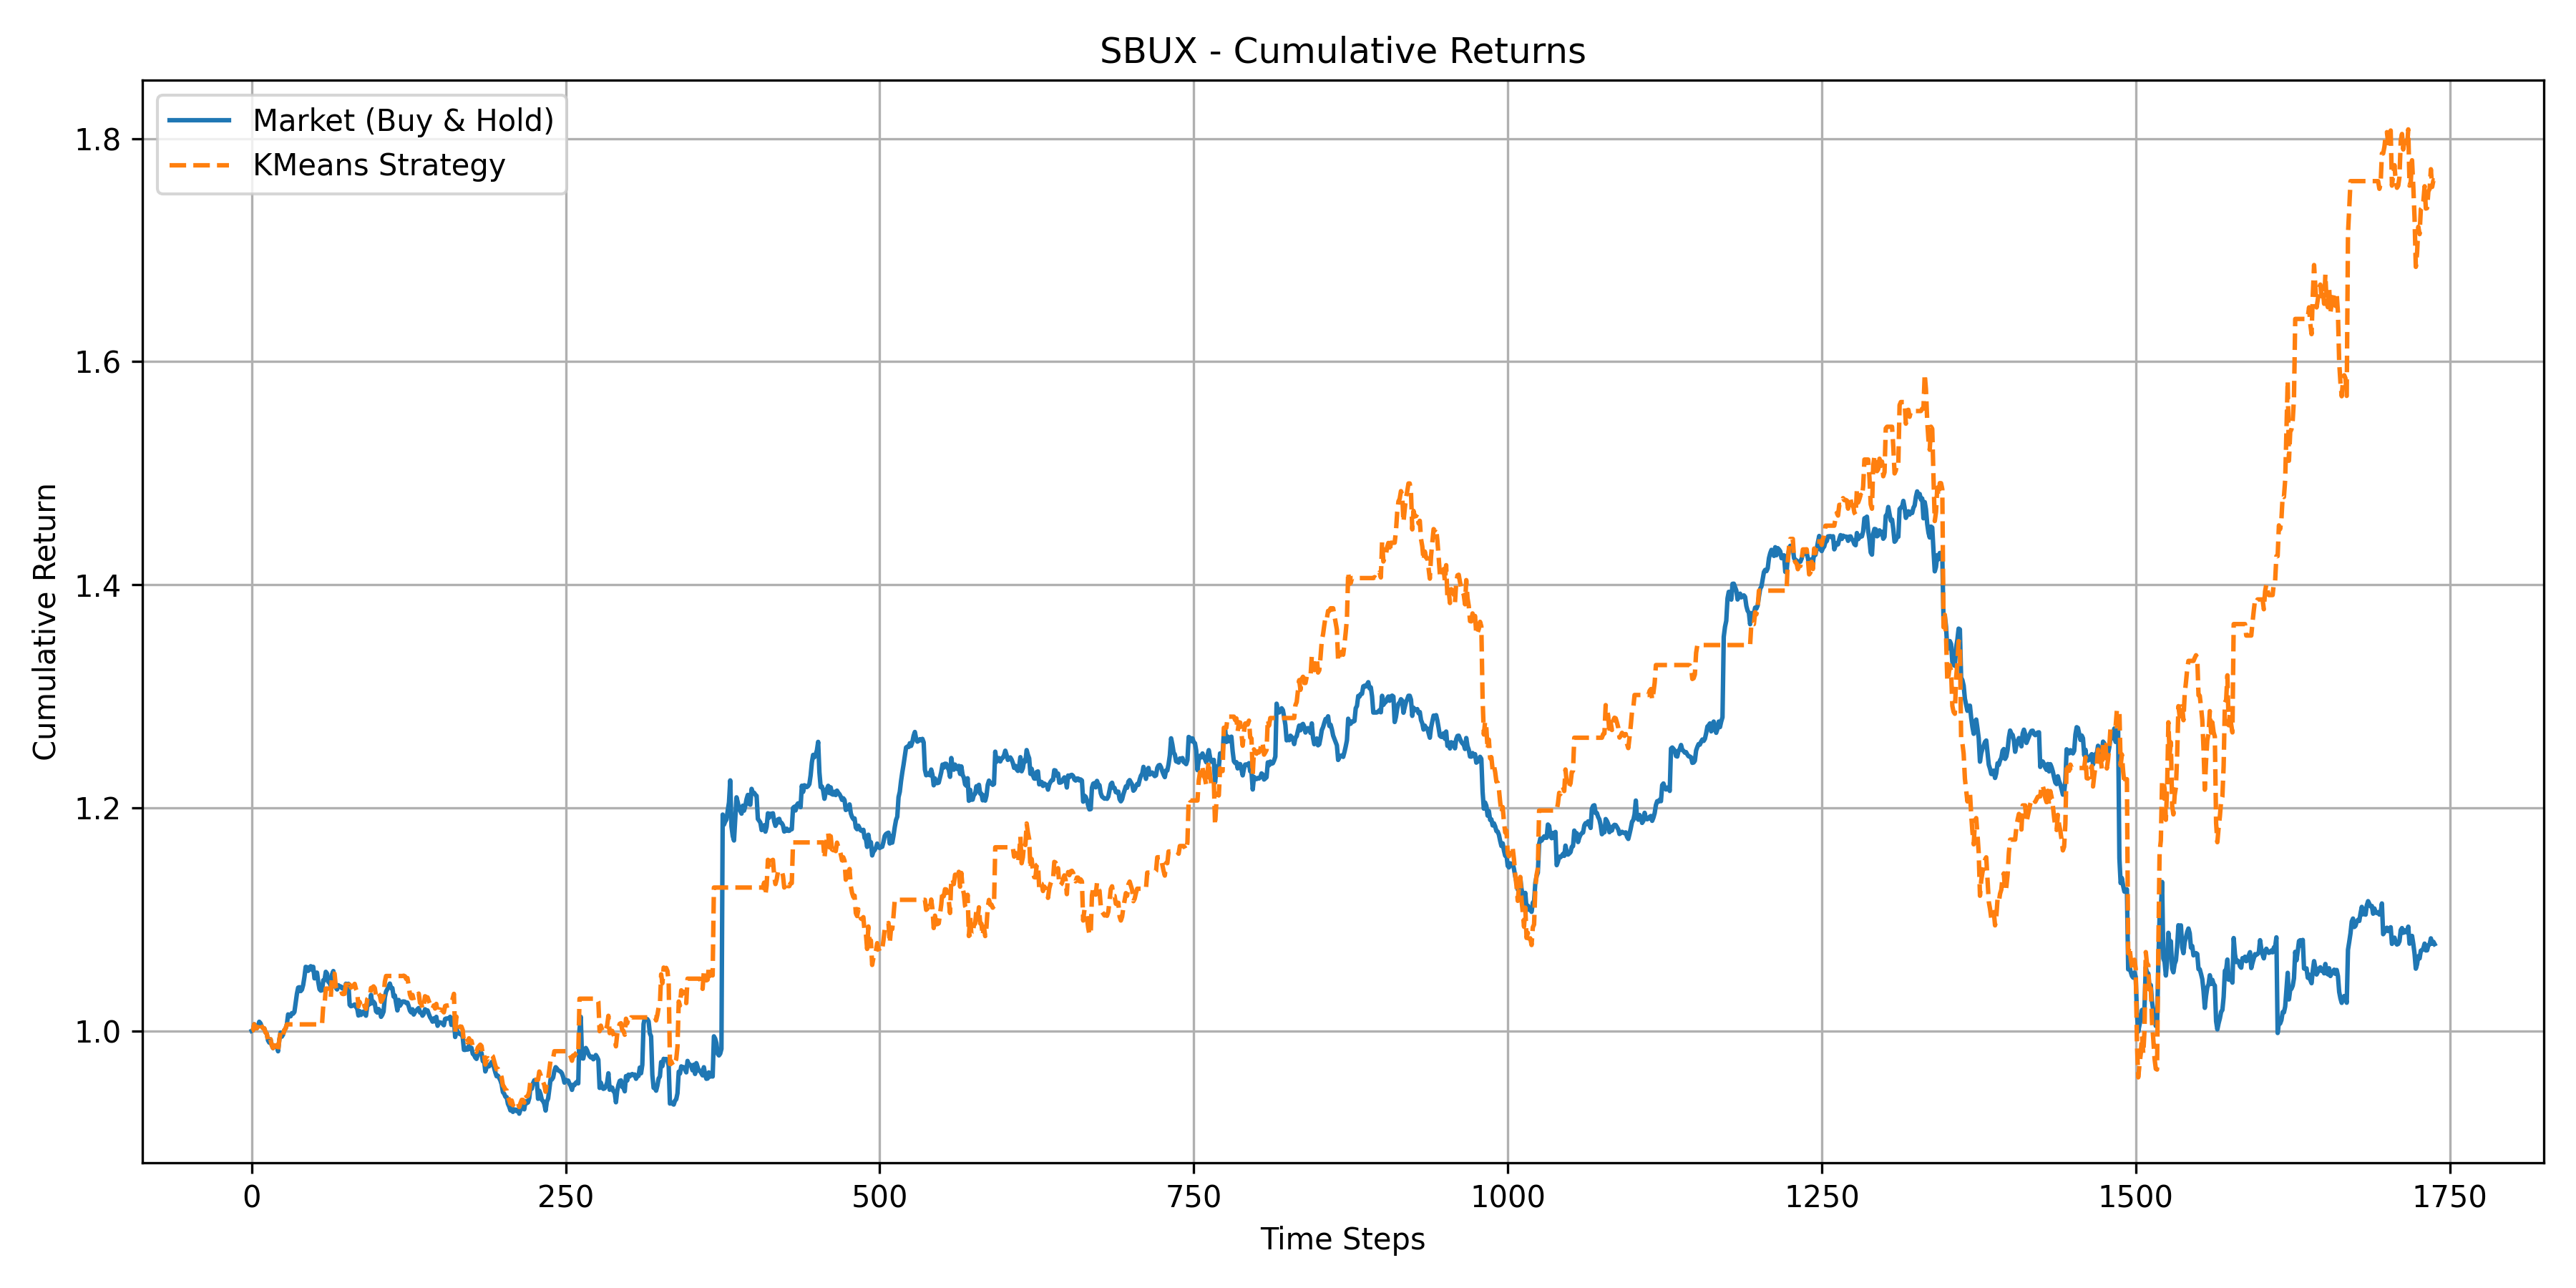


TSLA


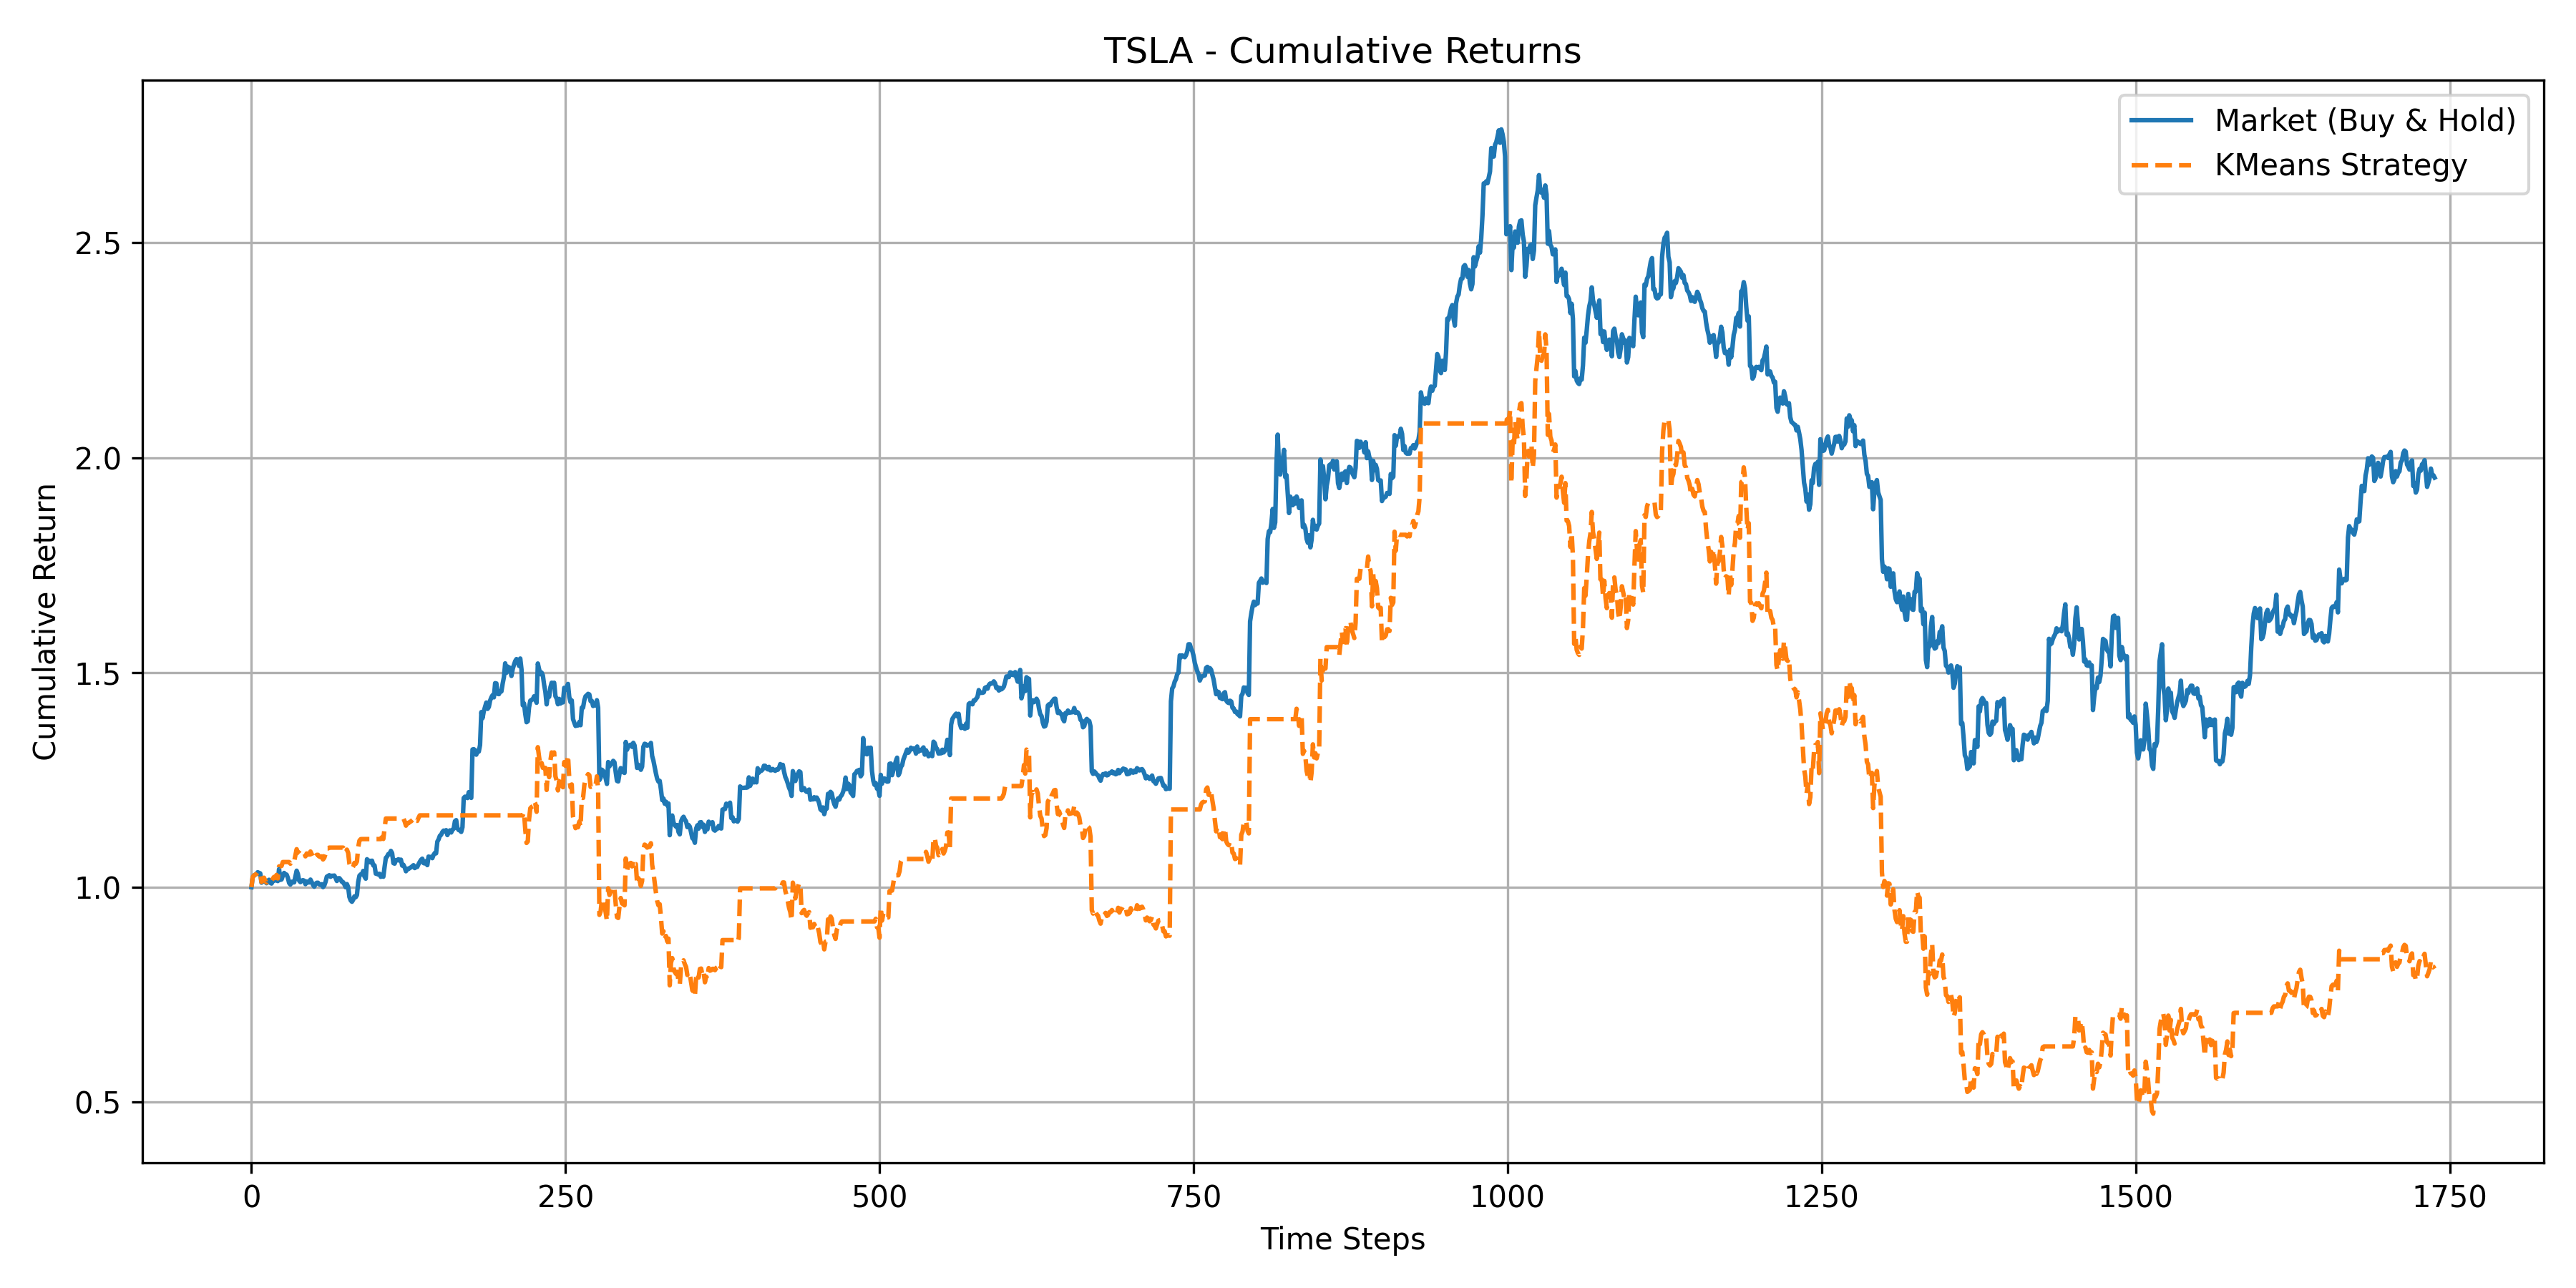


WMT


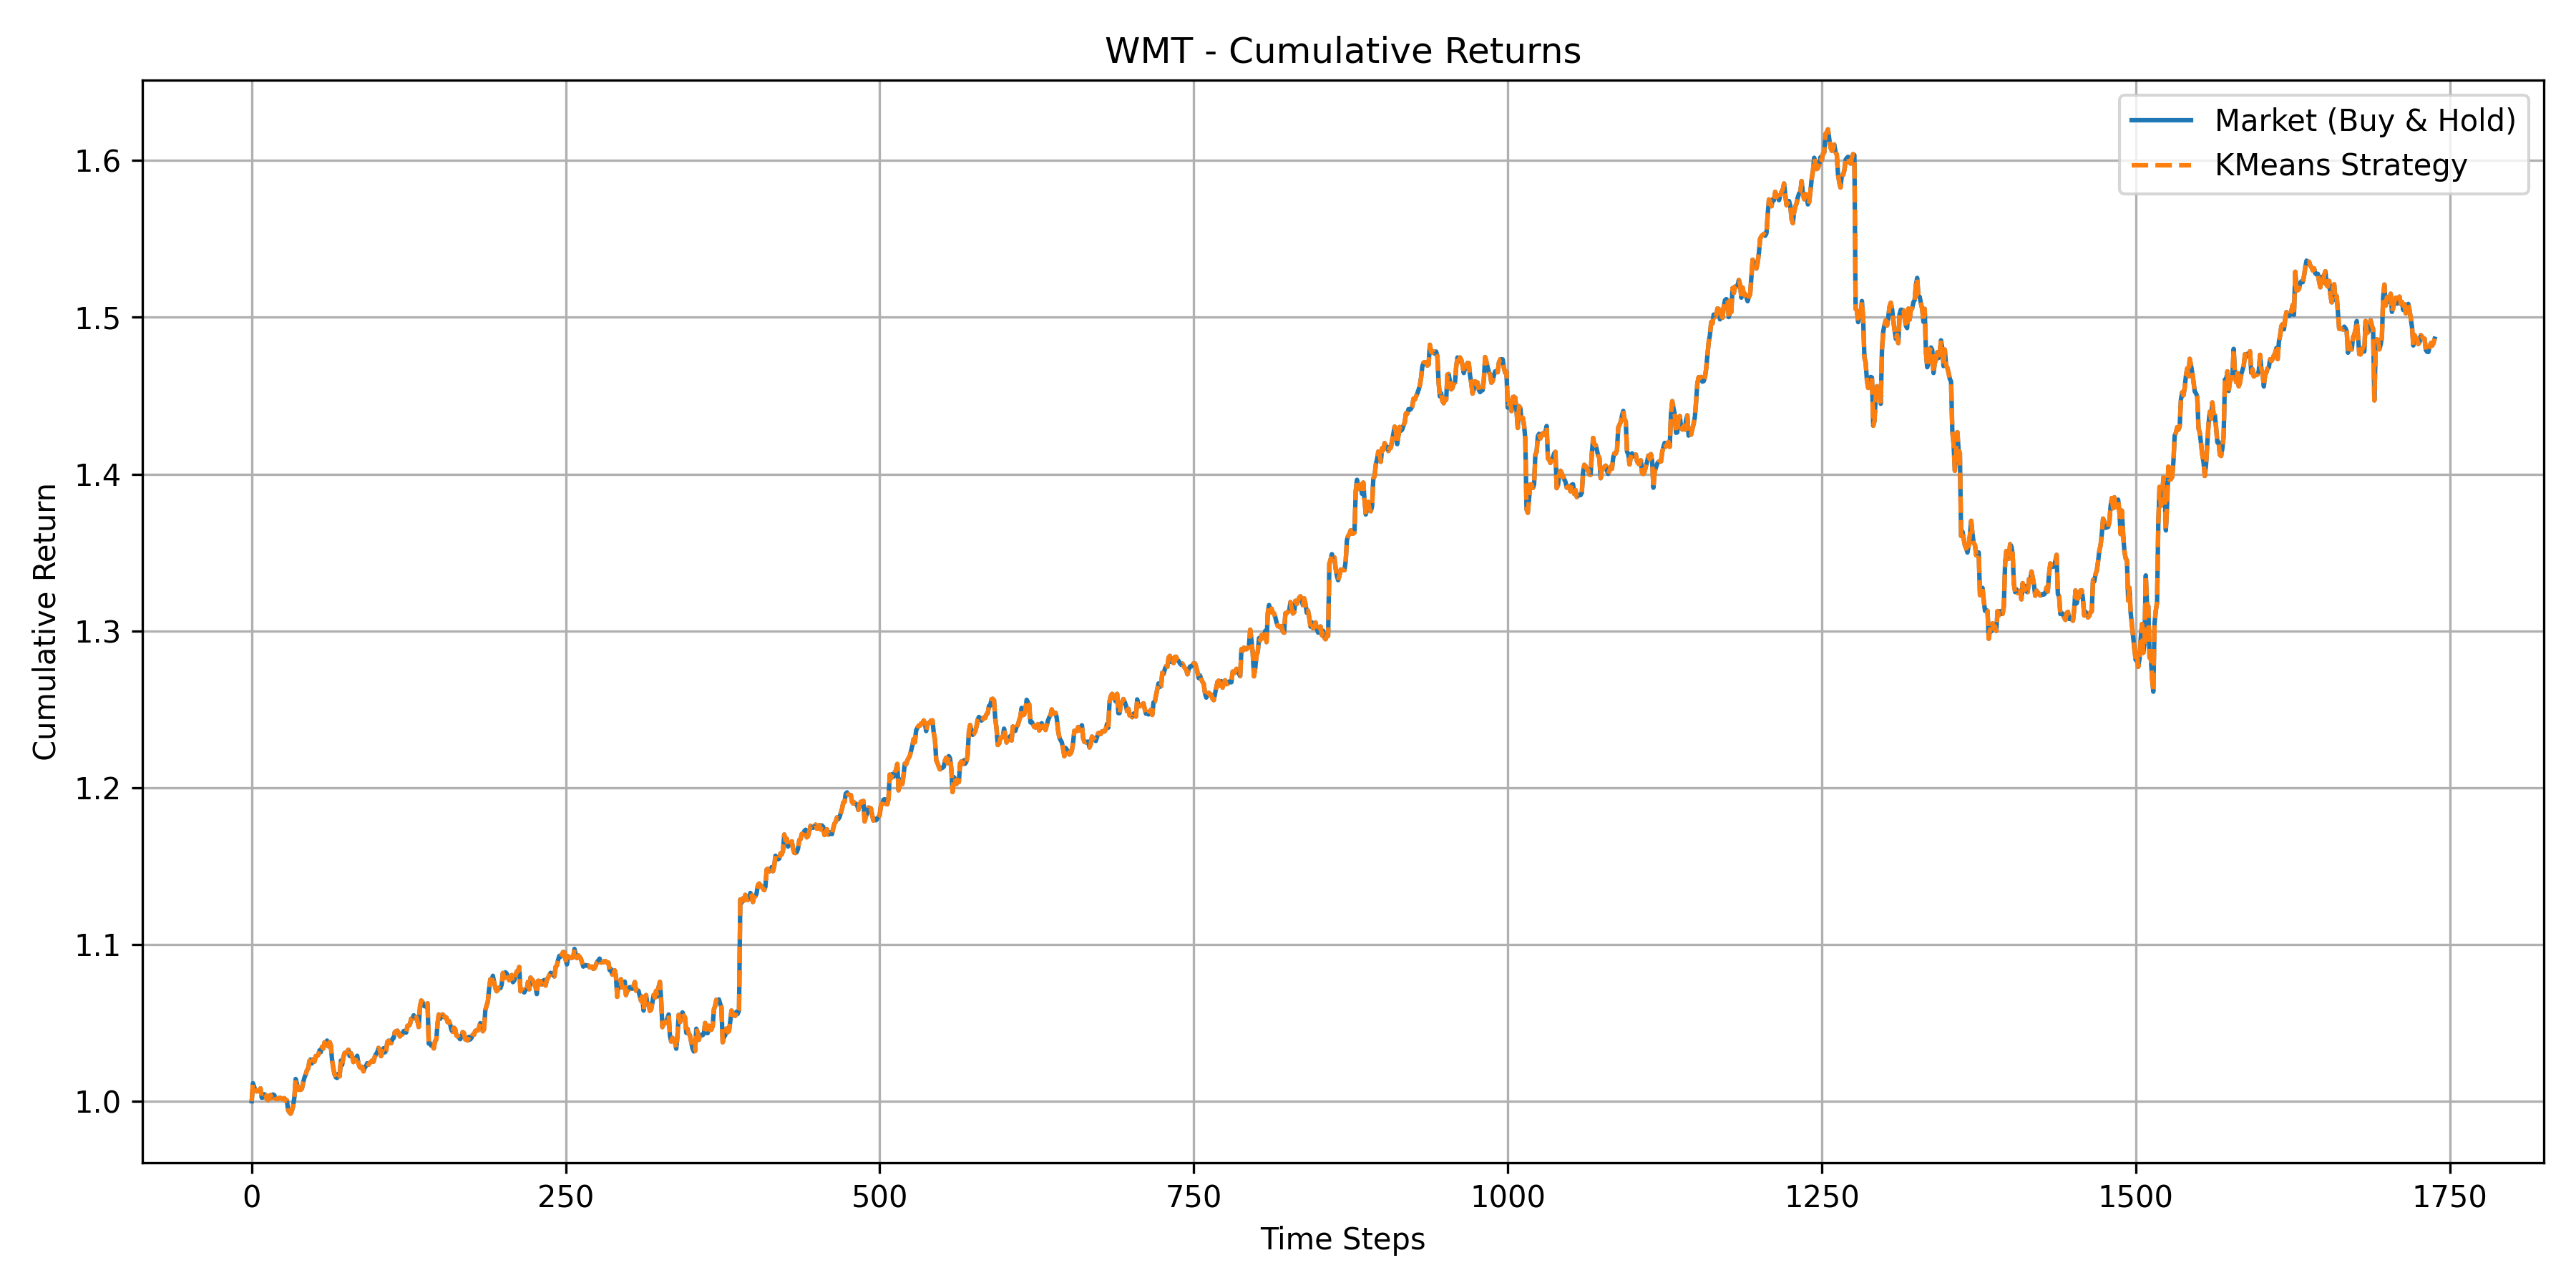


ABT


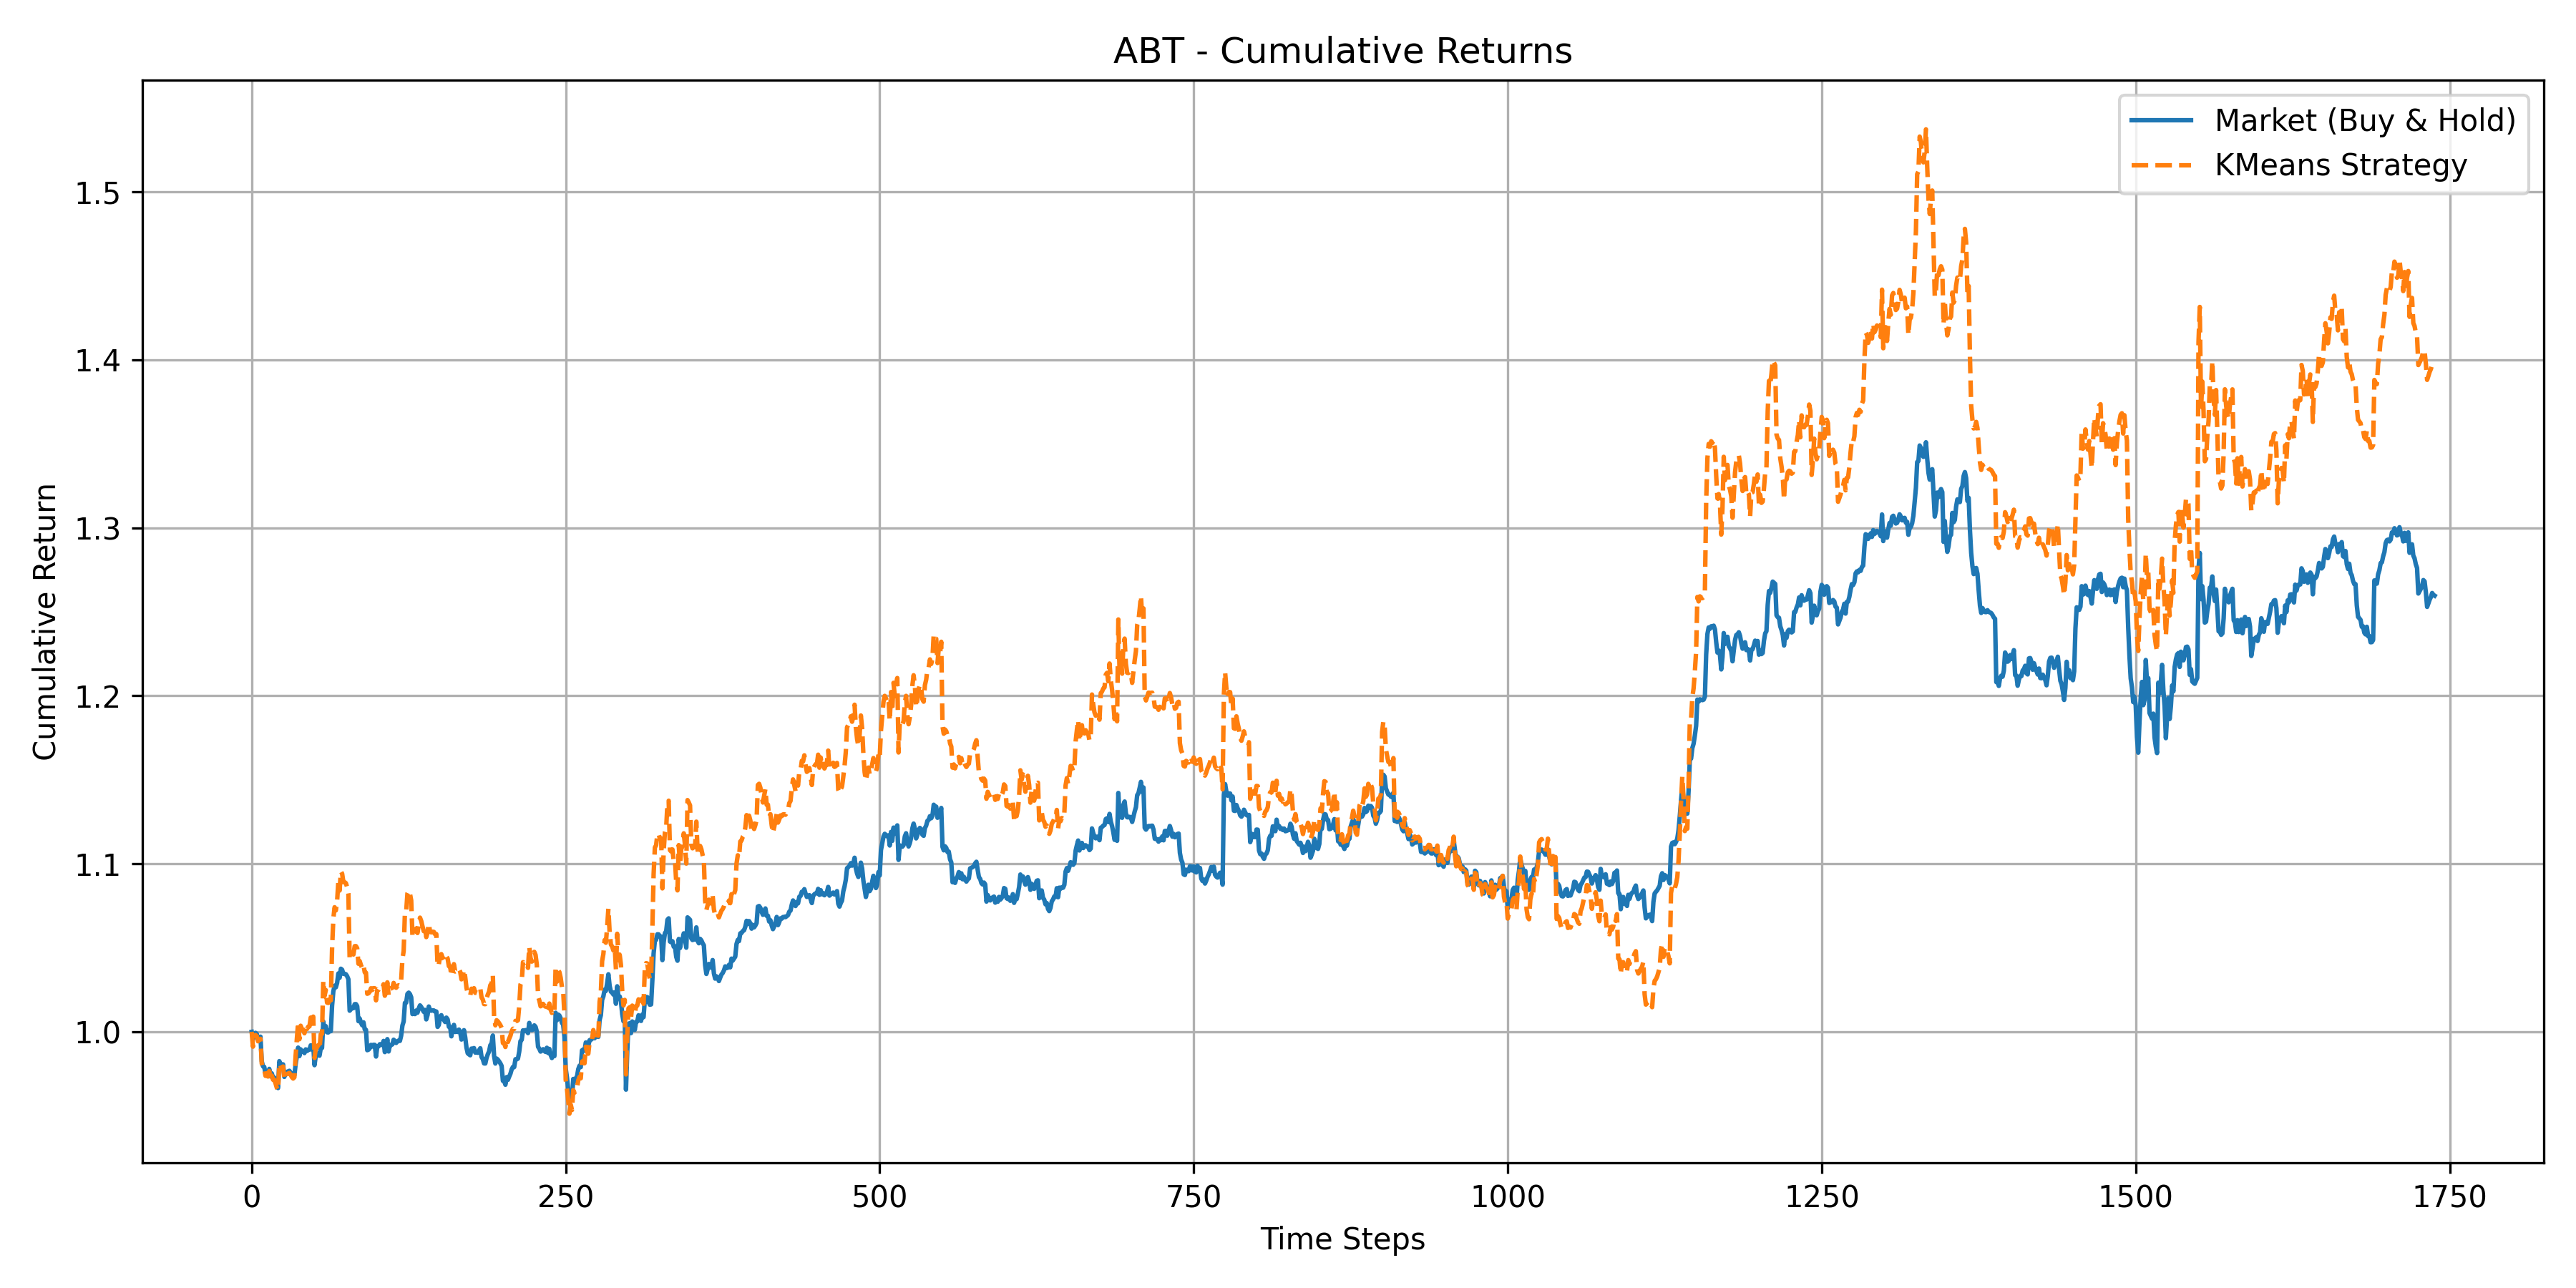


JPM


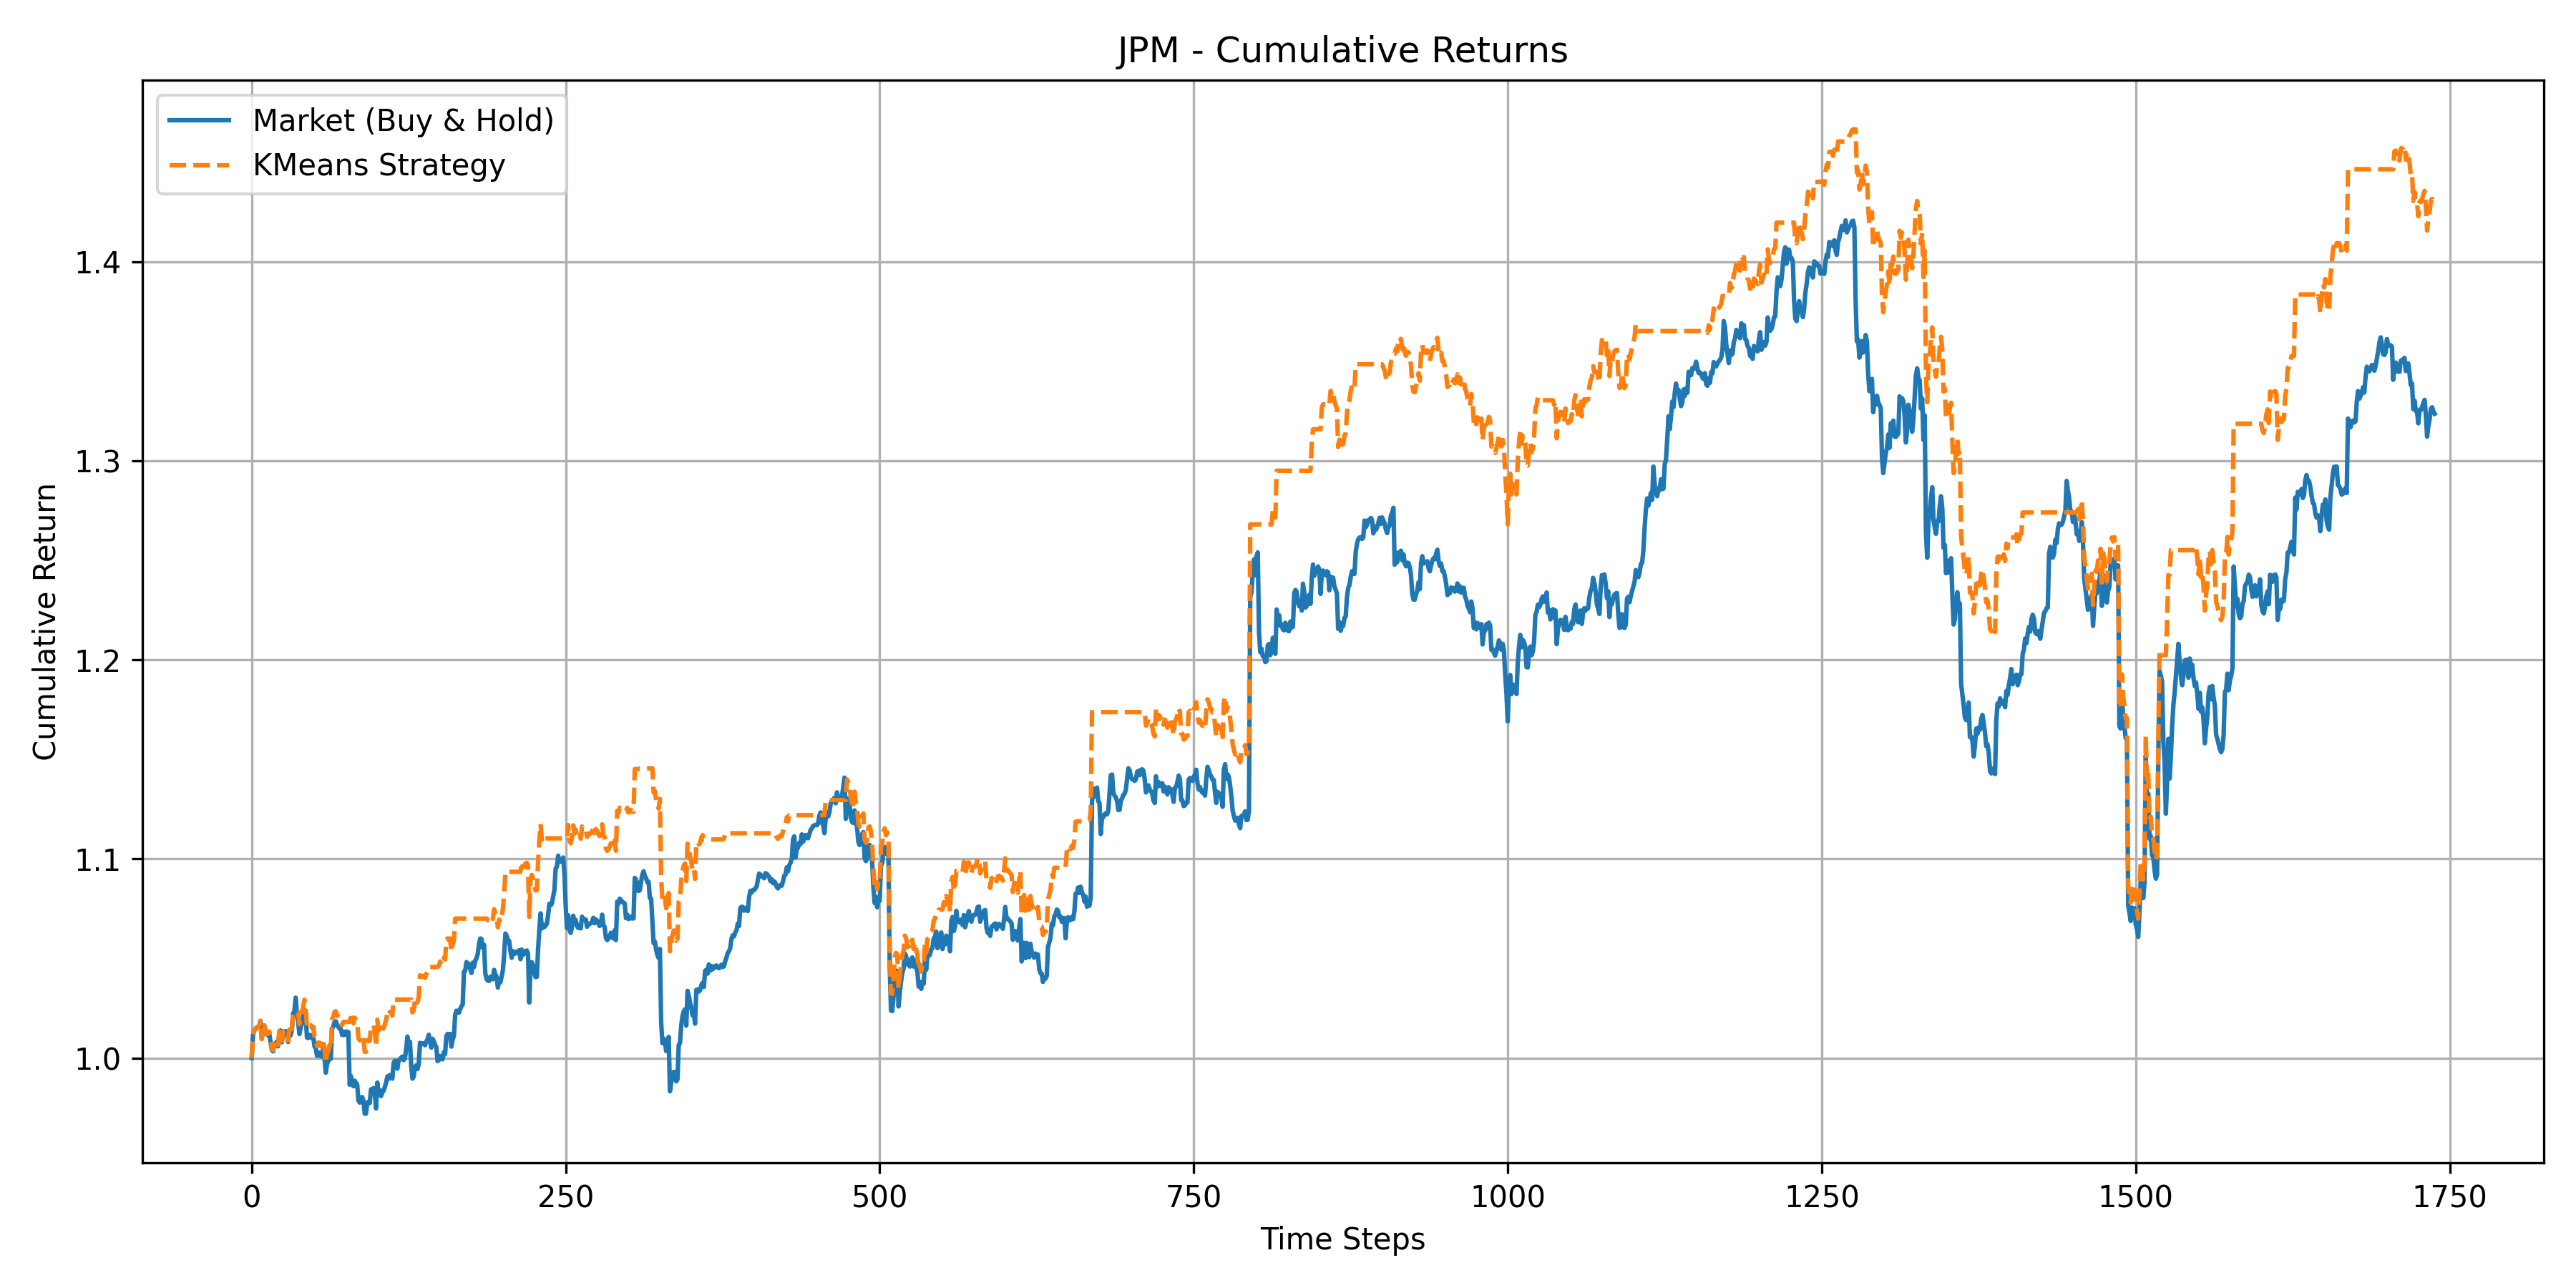

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# === Correct Google Drive Paths ===
base_dir = "/content/drive/MyDrive/Results_May_2025/kmeans_walkforward_results"
summary_path = f"{base_dir}/summary_forward_return_remap.csv"
plot_dir = f"{base_dir}/plots"
data_dir = f"{base_dir}/data"

# === Ensure plot directory exists ===
os.makedirs(plot_dir, exist_ok=True)

# === Load summary file ===
if not os.path.exists(summary_path):
    raise FileNotFoundError(f"Summary file not found at {summary_path}")

summary_df = pd.read_csv(summary_path)

# === Select Top 5 by Final Portfolio Value ===
top_tickers = summary_df.sort_values('Final Portfolio Value', ascending=False).head(5)['Ticker']

# === Plot cumulative returns ===
for ticker in top_tickers:
    file_path = f"{data_dir}/{ticker}_result.csv"

    if not os.path.exists(file_path):
        print(f"Result CSV not found for {ticker}: {file_path}")
        continue

    df = pd.read_csv(file_path)

    plt.figure(figsize=(12, 6))
    plt.plot(df['cumulative_market'], label='Market (Buy & Hold)', linestyle='-')
    plt.plot(df['cumulative_strategy'], label='KMeans Strategy', linestyle='--')
    plt.title(f"{ticker} - Cumulative Returns")
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plot_path = f"{plot_dir}/{ticker}_portfolio_plot.png"
    plt.savefig(plot_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Plot saved for {ticker}: {plot_path}")

# === Display saved plots inline ===
for ticker in top_tickers:
    img_path = f"{plot_dir}/{ticker}_portfolio_plot.png"
    if os.path.exists(img_path):
        print(f"\n{ticker}")
        display(Image(filename=img_path))
